# Tabular - Binary Classification using DNNs

By [Akshaj Verma](https://akshajverma.com/)

This notebook takes you through the implementation of binary classification using feedforward networks on the [lower back pain symptoms dataset](https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset) using PyTorch.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv("../../../data/tabular/classification/spine_dataset.csv")

## Pre-processing

In [4]:
df = df.iloc[:, 0:-1]

In [5]:
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


In [6]:
len(df)

310

In [7]:
df.describe()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694,0.472979,21.321526,13.064511,11.933317,-14.053139,25.645981
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027,0.285787,8.639423,3.399713,2.893265,12.225582,10.450558
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179,0.003220,7.027000,7.037800,7.030600,-35.287375,7.007900
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727,0.224367,13.054400,10.417800,9.541140,-24.289522,17.189075
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934,0.475989,21.907150,12.938450,11.953835,-14.622856,24.931950
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352,0.704846,28.954075,15.889525,14.371810,-3.497094,33.979600
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082,0.998827,36.743900,19.324000,16.821080,6.972071,44.341200


We observe that there's a class imbalance here. So, we need to perform stratified splitting here. 

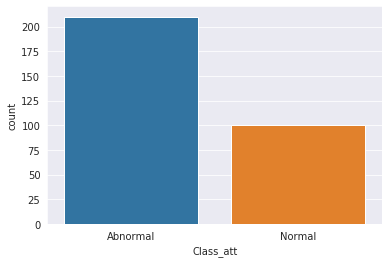

In [8]:
sns.countplot(x = 'Class_att', data=df)

In [9]:
df['Class_att'] = df['Class_att'].astype('category')

In [10]:
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

df['Class_att'].replace(encode_map, inplace=True)

In [11]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

## Train - Validation - Test

In [12]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [14]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [15]:
def get_class_distribution(obj):
    d = {
        "normal": 0,
        "abnormal": 0
    }
    
    for i in obj:
        if i == 0: 
            d['normal'] += 1
        elif i == 1: 
            d['abnormal'] += 1
        else:
            print("Check classes.")
            
    return d 

In [16]:
print(get_class_distribution(y_train))
print(get_class_distribution(y_test))
print(get_class_distribution(y_val))

{'normal': 72, 'abnormal': 151}
{'normal': 20, 'abnormal': 42}
{'normal': 8, 'abnormal': 17}


## Neural Net

### Model Parameters

In [42]:
EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.001
DROPOUT = 0.2

### Define Custom Dataloader

In [43]:
class TrainValData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = TrainValData(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = TrainValData(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = TrainValData(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [44]:
target_list = []

for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [45]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights

tensor([0.0139, 0.0066])

In [46]:
class_weights_all = class_weights[target_list]

In [47]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [48]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

### Define Neural Net Architecture

In [54]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        
        self.layer_1 = nn.Linear(12, 32) # Number of input features is 12.
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(32, 2) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm = nn.BatchNorm1d(32)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm(x)
        x = self.relu(x)
#         x = self.layer_2(x)
#         x = self.batchnorm(x)
#         x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [56]:
model = BinaryClassification()
model.to(device)

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=12, out_features=32, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=32, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Train Model

In [57]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.softmax(y_pred, dim = 1))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [58]:
print("Begin training.")
model.train()
for e in tqdm(range(1, EPOCHS+1)):
    train_epoch_loss = 0
    train_epoch_acc = 0
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
#         train_acc = binary_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
#         train_epoch_acc += train_acc.item()
        
        
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
#             val_acc = binary_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()
#             val_epoch_acc += train_acc.item()

    
        

    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} ')
#     | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}

Begin training.


Epoch 001: | Train Loss: 0.73943 | Val Loss: 0.75338 
Epoch 002: | Train Loss: 0.68475 | Val Loss: 0.68006 
Epoch 003: | Train Loss: 0.67716 | Val Loss: 0.66359 
Epoch 004: | Train Loss: 0.67098 | Val Loss: 0.67711 
Epoch 005: | Train Loss: 0.66311 | Val Loss: 0.67587 
Epoch 006: | Train Loss: 0.64178 | Val Loss: 0.62668 
Epoch 007: | Train Loss: 0.63696 | Val Loss: 0.60262 
Epoch 008: | Train Loss: 0.62829 | Val Loss: 0.61818 
Epoch 009: | Train Loss: 0.62658 | Val Loss: 0.63960 
Epoch 010: | Train Loss: 0.61049 | Val Loss: 0.64547 
Epoch 011: | Train Loss: 0.57406 | Val Loss: 0.51489 
Epoch 012: | Train Loss: 0.60755 | Val Loss: 0.60908 
Epoch 013: | Train Loss: 0.53886 | Val Loss: 0.45790 
Epoch 014: | Train Loss: 0.60502 | Val Loss: 0.56521 
Epoch 015: | Train Loss: 0.61651 | Val Loss: 0.63092 
Epoch 016: | Train Loss: 0.59485 | Val Loss: 0.61890 
Epoch 017: | Train Loss: 0.59029 | Val Loss: 0.62152 
Epoch 018: | Train Loss: 0.57837 | Val Loss: 0.67787 
Epoch 019: | Train Loss: 0.5

### Test Model

In [59]:
y_pred_list = []

model.eval()
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())

In [60]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

### Confusion Matrix

In [61]:
confusion_matrix(y_test, y_pred_list)

array([[18,  2],
       [18, 24]])

### Classification Report

In [62]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.50      0.90      0.64        20
           1       0.92      0.57      0.71        42

    accuracy                           0.68        62
   macro avg       0.71      0.74      0.67        62
weighted avg       0.79      0.68      0.69        62

